# Load data

In [5]:
import re
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as K
import keras_tuner as kt

from lib.utils import (
    normalize_mid_points,
    read_data,
    format_feature_names,
    save_tflite_model,
    apply_cart2pol_along_axis
)
from lib.keypoints import KEYPOINT_DICT

In [6]:
# punch types: hook, jab, uper

labels_by_punch_types = [
    ['id0_hook_1', 'id0_hook_2', 'id1_hook_1', 'id1_hook_2'],
    ['id0_jab_1', 'id0_jab_2', 'id1_jab_1', 'id1_jab_2'],
    ['id0_uper_1', 'id0_uper_2', 'id1_uper_1', 'id1_uper_2']
]

In [7]:
X_train_list = []
y_train_list = []
X_val_list = []
y_val_list = []

for labels in labels_by_punch_types:
    test_label = random.choice(labels)

    for label in [i for i in labels if i != test_label]:
        X, y = read_data(label, normalize_mp='2D', skip_midpoints=True)
        X_train_list.append(X)
        y_train_list.append(y)
    
    X, y = read_data(test_label, normalize_mp='2D', skip_midpoints=True)
    X_val_list.append(X)
    y_val_list.append(y)


X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)
X_val = np.concatenate(X_val_list)
y_val = np.concatenate(y_val_list)

(1100, 34)
(1051, 34)
(858, 34)
(792, 34)
(993, 34)
(802, 34)
(643, 34)
(952, 34)
(1186, 34)
(746, 34)
(703, 34)
(1200, 34)


In [8]:
X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)
X_val = np.concatenate(X_val_list)
y_val = np.concatenate(y_val_list)

In [9]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((8082, 34), (8082,), (2944, 34), (2944,))

In [13]:
feature_names = format_feature_names(list(KEYPOINT_DICT.keys()), ndims=2, skip_midpoints=True)

In [14]:
df = pd.DataFrame(data=X_train, columns=feature_names)

In [15]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nose-x,8082.0,-0.211063,0.022880,-0.464483,-0.224388,-0.212842,-0.199485,0.356807
nose-y,8082.0,0.003452,0.111973,-0.668847,-0.110593,0.042986,0.095116,0.321883
left_eye-x,8082.0,-0.223147,0.025503,-0.394743,-0.237245,-0.225154,-0.211449,0.356518
left_eye-y,8082.0,0.006113,0.110631,-0.627711,-0.103300,0.043040,0.095421,0.301342
right_eye-x,8082.0,-0.223402,0.024205,-0.407856,-0.237463,-0.225369,-0.211442,0.356240
right_eye-y,8082.0,-0.001077,0.109995,-0.669672,-0.109724,0.028445,0.087474,0.306070
left_ear-x,8082.0,-0.228746,0.023500,-0.474184,-0.243461,-0.231127,-0.216067,0.342778
left_ear-y,8082.0,0.004819,0.073950,-0.630785,-0.045234,0.011537,0.056043,0.293566
right_ear-x,8082.0,-0.229345,0.023138,-0.469636,-0.244179,-0.231966,-0.216725,0.338165
right_ear-y,8082.0,-0.014813,0.074050,-0.600943,-0.067169,-0.022236,0.032704,0.307987


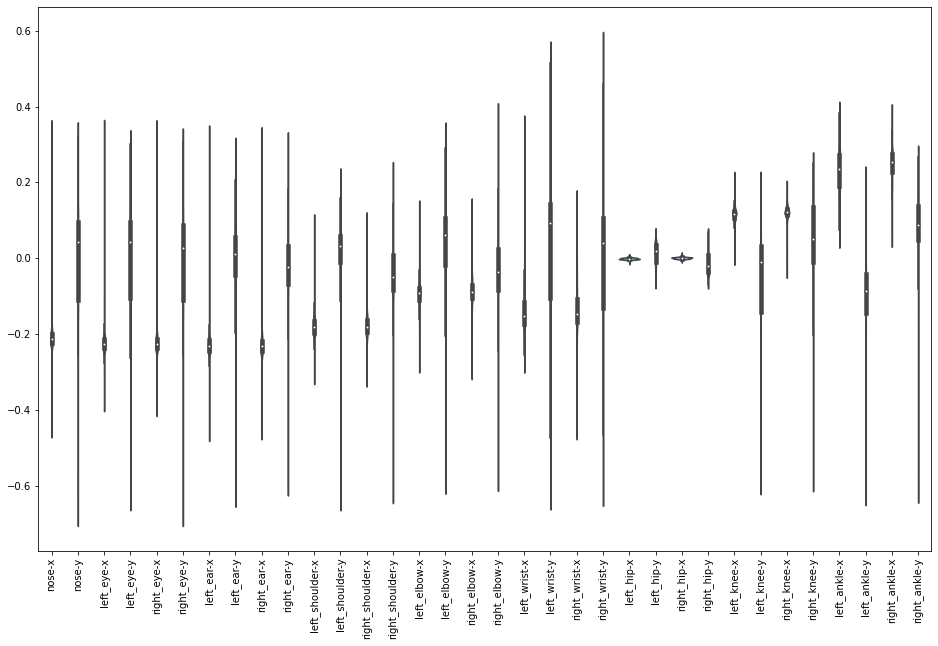

In [16]:
plt.figure(figsize=(16, 10))
ax = sns.violinplot(data=df)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [17]:
time_steps=30 # expect camera 30 fps, so process 1 sample per second
# Number of samples in batch
N_train = X_train.shape[0] // time_steps 
N_val = X_val.shape[0] // time_steps

In [19]:
X_train = X_train[:N_train*time_steps].reshape(-1, time_steps, 34)
y_train = y_train[:N_train*time_steps].reshape(-1, time_steps, 1)
X_val = X_val[:N_val*time_steps].reshape(-1, time_steps, 34)
y_val = y_val[:N_val*time_steps].reshape(-1, time_steps, 1)
X_train.shape, X_val.shape

((269, 30, 34), (98, 30, 34))

## GRU

In [20]:
y_train = K.utils.to_categorical(y_train, num_classes=7)
X_train = tf.constant(X_train)
y_val = K.utils.to_categorical(y_val, num_classes=7)
X_val = tf.constant(X_val)

2021-11-23 12:56:59.930190: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-11-23 12:57:00.850996: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-11-23 12:57:00.851045: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: andrew-Aspire-A715-41G
2021-11-23 12:57:00.851053: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: andrew-Aspire-A715-41G
2021-11-23 12:57:00.851275: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.82.0
2021-11-23 12:57:00.851301: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.82.0
2021-11-23 12:57:00.851307: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.82.0
2021-11-23 12:57:00.851789: I tensorflow/core/platform/cpu_fe

In [21]:
def model_builder(hp):
    # Hyperparams
    hp_ru = hp.Int('recurrent_units', min_value=16, max_value=128, step=8)
    hp_du1 = hp.Int('units1', min_value=16, max_value=128, step=8)
    hp_du2 = hp.Int('units2', min_value=16, max_value=128, step=8)
    hp_reg1 = hp.Float('dense1_reg', min_value=1e-4, max_value=1e-2)
    hp_reg2 = hp.Float('dense2_reg', min_value=1e-4, max_value=1e-2)
    
    hp_dp = hp.Float('dropout', min_value=0., max_value=0.4)
    hp_rec_dp = hp.Float('rec_dropout', min_value=0., max_value=0.4)
    hp_kernel_reg = hp.Float('kernel_reg', min_value=1e-5, max_value=1e-3, sampling='log')
    hp_recur_reg = hp.Float('recur_reg', min_value=1e-5, max_value=1e-3, sampling='log')
    hp_act_reg = hp.Float('act_reg', min_value=1e-5, max_value=1e-3, sampling='log')
    
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2)

    
    # Model
    norm = tf.keras.layers.LayerNormalization(axis=1)
    kernel_reg = K.regularizers.l2(hp_kernel_reg)
    recurrent_reg = K.regularizers.l2(hp_recur_reg)
    act_reg = K.regularizers.l2(hp_act_reg)
    lstm = K.layers.GRU(hp_ru,
                         # stateful=True, # mutable states not supported in tflite 
                         return_sequences=True,
                         kernel_regularizer=kernel_reg,
                         recurrent_regularizer=recurrent_reg,
                         activity_regularizer=act_reg,
                         dropout=hp_dp,
                         recurrent_dropout=hp_rec_dp
                        )
    dense1 = K.layers.Dense(hp_du1, activation='relu', 
                            kernel_regularizer=K.regularizers.l2(hp_reg1))
    dense2 = K.layers.Dense(hp_du2, activation='relu', 
                           kernel_regularizer=K.regularizers.l2(hp_reg2))
    out = K.layers.Dense(7, activation='sigmoid')

    model = K.Sequential([norm, lstm, dense1, dense2, out])
    model.compile(optimizer=K.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [22]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     directory='kt_dir2',
                     project_name='punch_dl_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

tuner.search(X_train, y_train, batch_size=1, validation_data=(X_val, y_val), 
             epochs=32, callbacks=[stop_early])

Trial 30 Complete [00h 01m 44s]
val_accuracy: 0.6748299598693848

Best val_accuracy So Far: 0.7010204195976257
Total elapsed time: 00h 18m 07s
INFO:tensorflow:Oracle triggered exit


In [23]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps.values

{'recurrent_units': 88,
 'units1': 56,
 'units2': 56,
 'dense1_reg': 0.004625559119323045,
 'dense2_reg': 0.004128083938236285,
 'dropout': 0.045081307358864425,
 'rec_dropout': 0.10082452744266553,
 'kernel_reg': 1.4518980054608056e-05,
 'recur_reg': 0.0008467013936377785,
 'act_reg': 0.00012789451776909946,
 'learning_rate': 0.001288850534891612,
 'tuner/epochs': 3,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [24]:
# Build the model with the optimal hyperparameters and train it on the data for 64 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, batch_size=1, 
                    validation_data=(X_val, y_val), 
                    epochs=64,
                   callbacks=[K.callbacks.ReduceLROnPlateau()])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/64
269/269 [==============================] - 5s 17ms/step - loss: 1.8344 - accuracy: 0.5172 - val_loss: 1.3857 - val_accuracy: 0.5888
Epoch 2/64
269/269 [==============================] - 4s 15ms/step - loss: 1.2772 - accuracy: 0.6154 - val_loss: 1.2073 - val_accuracy: 0.6531
Epoch 3/64
269/269 [==============================] - 4s 14ms/step - loss: 1.1006 - accuracy: 0.6616 - val_loss: 1.2211 - val_accuracy: 0.6670
Epoch 4/64
269/269 [==============================] - 4s 15ms/step - loss: 0.9954 - accuracy: 0.6942 - val_loss: 1.1618 - val_accuracy: 0.6905
Epoch 5/64
269/269 [==============================] - 4s 16ms/step - loss: 0.9178 - accuracy: 0.7244 - val_loss: 1.1622 - val_accuracy: 0.6847
Epoch 6/64
269/269 [==============================] - 4s 16ms/step - loss: 0.8694 - accuracy: 0.7454 - val_loss: 1.1681 - val_accuracy: 0.6636
Epoch 7/64
269/269 [==============================] - 4s 16ms/step - loss: 0.8059 - accuracy: 0.7736 - val_loss: 1.2061 - val_accuracy: 0.6752

Epoch 58/64
269/269 [==============================] - 5s 18ms/step - loss: 0.4040 - accuracy: 0.9411 - val_loss: 1.5677 - val_accuracy: 0.6905
Epoch 59/64
269/269 [==============================] - 5s 18ms/step - loss: 0.4063 - accuracy: 0.9403 - val_loss: 1.5677 - val_accuracy: 0.6905
Epoch 60/64
269/269 [==============================] - 5s 18ms/step - loss: 0.4071 - accuracy: 0.9418 - val_loss: 1.5677 - val_accuracy: 0.6905
Epoch 61/64
269/269 [==============================] - 5s 19ms/step - loss: 0.4062 - accuracy: 0.9395 - val_loss: 1.5677 - val_accuracy: 0.6905
Epoch 62/64
269/269 [==============================] - 5s 19ms/step - loss: 0.4050 - accuracy: 0.9430 - val_loss: 1.5678 - val_accuracy: 0.6905
Epoch 63/64
269/269 [==============================] - 5s 18ms/step - loss: 0.4054 - accuracy: 0.9414 - val_loss: 1.5678 - val_accuracy: 0.6905
Epoch 64/64
269/269 [==============================] - 5s 19ms/step - loss: 0.4080 - accuracy: 0.9413 - val_loss: 1.5678 - val_accuracy:

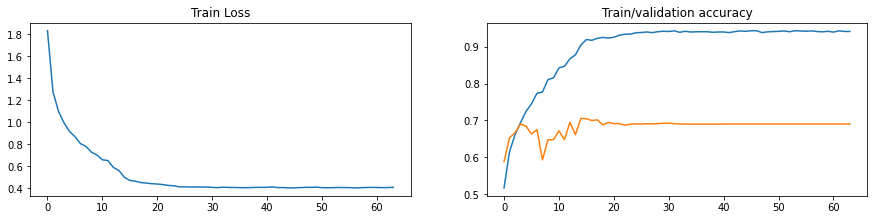

In [25]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Conclusion 

We need more data to avoid overfitting

# Convert the model

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) 

tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2021-11-23 13:50:55.571283: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpbzvki7c5/assets


2021-11-23 13:50:58.359080: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2021-11-23 13:50:58.359213: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2021-11-23 13:50:58.372107: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:816] Optimization results for grappler item: graph_to_optimize
2021-11-23 13:50:58.372144: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:818]   function_optimizer: Graph size after: 207 nodes (0), 234 edges (0), time = 2.152ms.
2021-11-23 13:50:58.372147: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:818]   function_optimizer: Graph size after: 207 nodes (0), 234 edges (0), time = 2.325ms.
2021-11-23 13:50:58.372150: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:816] Optimization results for grappler item: sequential_1_gru_1_while_cond_353211
2021-11-23 13:50:58.372153: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:818

In [27]:
# Save the model.
save_tflite_model(tflite_model, 'tflite_models')

In [29]:
# Run the model with TensorFlow to get expected results.
TEST_CASES = 10
x = tf.reshape(X_val, (-1, time_steps, 34))
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for i in range(TEST_CASES):
    expected = model.predict(x[i:i+1])
    interpreter.set_tensor(input_details[0]["index"], x[i:i+1])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])

    # Assert if the result of TFLite model is consistent with the TF model.
    np.testing.assert_almost_equal(expected, result, decimal=5)
    print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

    # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
    # the states.
    # Clean up internal states.
    interpreter.reset_all_variables()

Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.


# Moving most frequent smoothing

In [30]:
y_pred = np.argmax(model(x).numpy(), axis=-1).ravel()
y_val_np = np.concatenate(y_val_list)[:N_val*time_steps]

In [31]:
# [1,1,1,1,3,3,1,1] -> [1]
# moving window across padded y_pred
# output element is most frequent in window

win_size = time_steps // 2
mf_smooth = np.zeros(y_pred.shape[0]+win_size)
for i in range(len(y_pred) - win_size):
    window = y_pred[i:i+win_size]
    bins = np.bincount(window)
    mf_smooth[i+win_size//2] = np.argmax(bins)

mf_smooth = mf_smooth[:-win_size]

In [32]:
len(mf_smooth), len(y_pred), len(y_val_np)

(2940, 2940, 2940)

In [33]:
print(np.mean(y_val_np==y_pred))
print(np.mean(y_val_np==mf_smooth))

0.6904761904761905
0.7170068027210884


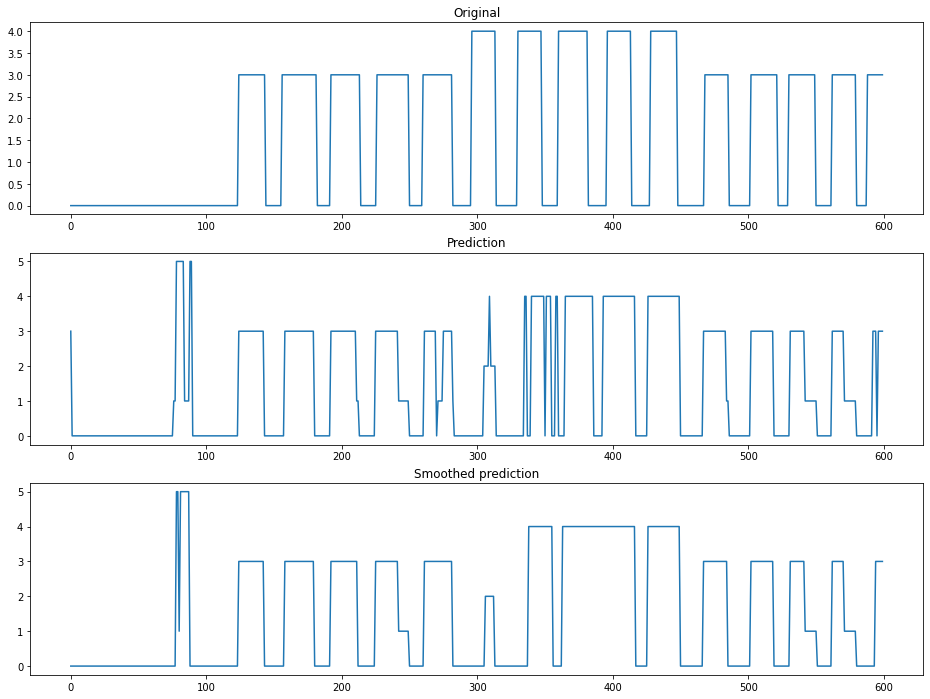

In [34]:
plt.figure(figsize=(16, 12))

plt.subplot(3, 1, 1)
plt.title('Original')
plt.plot(y_val_np[:600])

plt.subplot(3, 1, 2)
plt.title('Prediction')
plt.plot(y_pred[:600])

plt.subplot(3, 1, 3)
plt.title('Smoothed prediction')
plt.plot(mf_smooth[:600])


Thanks to:  
https://github.com/keras-team/keras-tuner